In [1]:
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2
import seaborn as sns

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [2]:
Thickness = pd.read_csv('./data/Thickness.csv')
Thickness = Thickness.drop([33]) # 9-1 drop
Thickness.reset_index(drop=True, inplace=True)
Thickness

,Thickness
0,48.266667
1,47.966667
2,48.166667
3,48.600000
4,59.533333
...,...
122,84.633333
123,98.366667
124,97.033333
125,96.266667


In [3]:
img_path_list = []
Top_change_imp_VS_path = './data/box_img/Top_change_VS_imp/'

for i in range(1, 33):
    for j in range(1, 5):
        if i == 9 and j == 1: 
            continue
        img_path_list.append('./data/test_img/AI-{}_0{}_transformed.jpg'.format(i, j))

전처리한 이미지 RGB / HSV

In [4]:
top_avg_bgr = []
top_avg_hsv = []

for i in range(len(img_path_list)):
    # 이미지 로드
    img = cv2.cvtColor(np.array(Image.open(Top_change_imp_VS_path + 'Top_change_VS_{}.jpg'.format(i))), cv2.COLOR_RGB2BGR)
    # RGB 평균 계산
    avg_bgr = img.mean(axis=(0,1))
    top_avg_bgr.append(avg_bgr)
    # HSV 평균 계산
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    avg_hsv = img_hsv.mean(axis=(0,1))
    top_avg_hsv.append(avg_hsv)

In [5]:
Table_dataset = pd.DataFrame({'Top_R' : [i[2] for i in top_avg_bgr], 
                              'Top_G' : [i[1] for i in top_avg_bgr], 
                              'Top_B' : [i[0] for i in top_avg_bgr],
                              'Top_H' : [i[0] for i in top_avg_hsv], 
                              'Top_S' : [i[1] for i in top_avg_hsv], 
                              'Top_V' : [i[2] for i in top_avg_hsv],
                              'Thickness': Thickness['Thickness']})

Table_dataset

,Top_R,Top_G,Top_B,Top_H,Top_S,Top_V,Thickness
0,11.5752,10.8824,8.0332,22.1580,79.0864,11.5752,48.266667
1,10.2804,10.4340,9.0232,23.5584,41.5664,10.5508,47.966667
2,10.0228,9.9236,7.9204,29.0352,56.4348,10.0308,48.166667
3,8.3744,8.5136,6.1348,26.7236,77.8136,8.6560,48.600000
4,4.1716,2.2884,1.1488,27.9292,211.7900,4.3000,59.533333
...,...,...,...,...,...,...,...
122,1.8884,5.0128,18.5152,114.3780,229.4796,18.5152,84.633333
123,6.9784,15.3760,26.5632,106.8272,188.4016,26.5632,98.366667
124,3.3400,13.3692,33.3720,109.8596,230.0004,33.3720,97.033333
125,5.8372,15.0308,31.7036,109.2272,208.5904,31.7036,96.266667


안쓸피쳐드랍

In [6]:
Table_dataset = Table_dataset.drop(['Top_R'], axis=1)
Table_dataset

,Top_G,Top_B,Top_H,Top_S,Top_V,Thickness
0,10.8824,8.0332,22.1580,79.0864,11.5752,48.266667
1,10.4340,9.0232,23.5584,41.5664,10.5508,47.966667
2,9.9236,7.9204,29.0352,56.4348,10.0308,48.166667
3,8.5136,6.1348,26.7236,77.8136,8.6560,48.600000
4,2.2884,1.1488,27.9292,211.7900,4.3000,59.533333
...,...,...,...,...,...,...
122,5.0128,18.5152,114.3780,229.4796,18.5152,84.633333
123,15.3760,26.5632,106.8272,188.4016,26.5632,98.366667
124,13.3692,33.3720,109.8596,230.0004,33.3720,97.033333
125,15.0308,31.7036,109.2272,208.5904,31.7036,96.266667


데이터 나누기

In [7]:
X_train, X_test, y_train, y_test = train_test_split(Table_dataset.iloc[:, :-1], Table_dataset.iloc[:, -1], test_size=0.3, random_state=42)

TPOT모델 찾기

# 🎯모델 1

In [8]:
from tpot import TPOTRegressor

tpot =  TPOTRegressor(generations=20, population_size=5, verbosity=2, random_state=42, cv=3, n_jobs = -1)
tpot.fit(X_train, y_train)

tpot.export('tpot_pipeline_cv.py')

                                                                            
Generation 1 - Current best internal CV score: -146.29320544880736
                                                                             
Generation 2 - Current best internal CV score: -146.29320544880736
                                                                             
Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=1.0, loss=exponential, n_estimators=100)


In [9]:
y_pred = tpot.predict(X_test)
y_pred

array([ 74.4       ,  62.83333333,  74.82380952, 102.996875  ,
        92.93174603,  62.82222222,  74.58148148,  93.24166666,
        62.82222222, 104.08292683,  99.96203703,  62.92083333,
        87.20882353,  74.40606061,  79.69803921, 102.0505747 ,
        86.27210884,  79.73333333,  63.03809524,  84.67857143,
        62.06666667,  62.83333333,  82.98070175, 120.46666668,
        59.8       , 105.07460317, 104.90119047, 104.06190476,
        74.40392157,  83.47777778,  64.18333334,  75.08095238,
        75.49555555, 104.06190476,  92.93174603,  98.98505747,
        74.58148148, 153.3       ,  75.08095238])

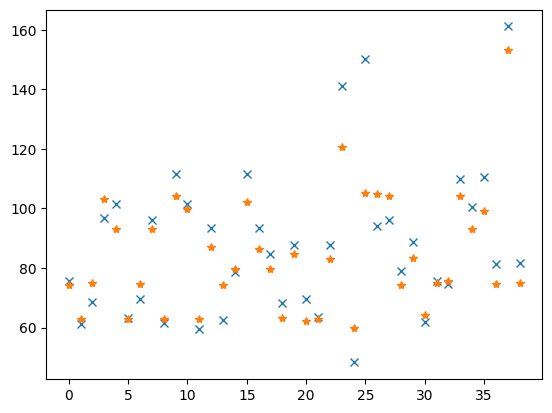

In [10]:
plt.plot(y_test.values,'x', label = 'True')
plt.plot(y_pred,'*', label = 'Predict')

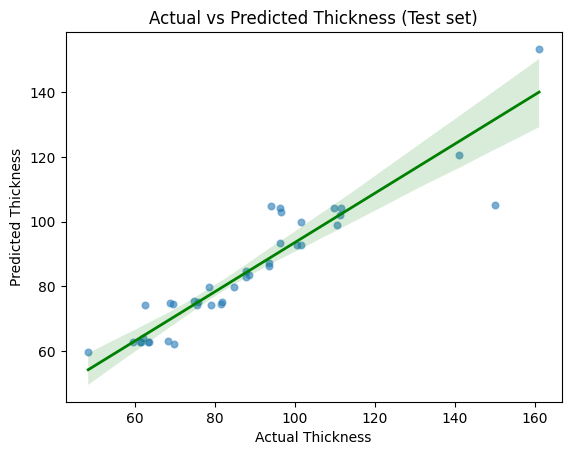

In [11]:
# Plotting the actual vs predicted values
sns.scatterplot(x=y_test.values, y=y_pred, alpha=0.4)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, robust=True)

plt.xlabel('Actual Thickness')
plt.ylabel('Predicted Thickness')
plt.title('Actual vs Predicted Thickness (Test set)')
plt.show()

In [12]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,75.533333,74.400000
1,61.300000,62.833333
2,68.700000,74.823810
3,96.633333,102.996875
4,101.466667,92.931746
5,63.166667,62.822222
6,69.433333,74.581481
7,96.266667,93.241667
8,61.466667,62.822222
9,111.533333,104.082927


In [13]:
mse = np.mean((y_pred - y_test)**2)
mse

100.65081746492316

In [14]:
# 테스트 세트에서의 RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

10.032488099415975

# 🎯 모델 2

In [15]:
tpot =  TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, cv=5, n_jobs = -1)
tpot.fit(X_train, y_train)

tpot.export('tpot_pipeline_cv.py')

                                                                             
Generation 1 - Current best internal CV score: -86.9571969096237
                                                                              
Generation 2 - Current best internal CV score: -86.9571969096237
                                                                              
Generation 3 - Current best internal CV score: -82.38253004528414
                                                                              
Generation 4 - Current best internal CV score: -81.2271892257603
                                                                              
Generation 5 - Current best internal CV score: -81.2271892257603
                                                                              
Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=4, min_samples_leaf=3, min_samples_split=17)


In [16]:
y_pred = tpot.predict(X_test)
y_pred

array([ 73.82      ,  60.03541667,  73.82      , 104.98095238,
        96.83809524,  60.03541667,  73.82      ,  96.83809524,
        60.03541667, 104.98095238,  96.83809524,  60.03541667,
        83.27407407,  73.82      ,  80.21481481, 104.98095238,
        84.40277778,  80.21481481,  60.03541667,  84.40277778,
        60.03541667,  60.03541667,  84.40277778, 118.02777778,
       118.02777778, 118.02777778, 104.98095238, 104.98095238,
        73.82      ,  84.40277778,  60.03541667,  73.82      ,
        73.82      , 104.98095238,  96.83809524,  96.83809524,
        73.82      , 118.02777778,  73.82      ])

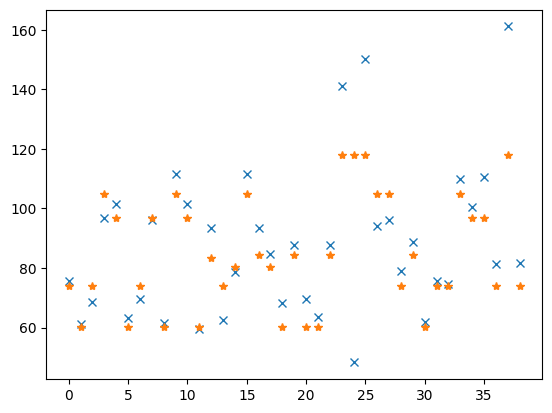

In [17]:
plt.plot(y_test.values,'x', label = 'True')
plt.plot(y_pred,'*', label = 'Predict')

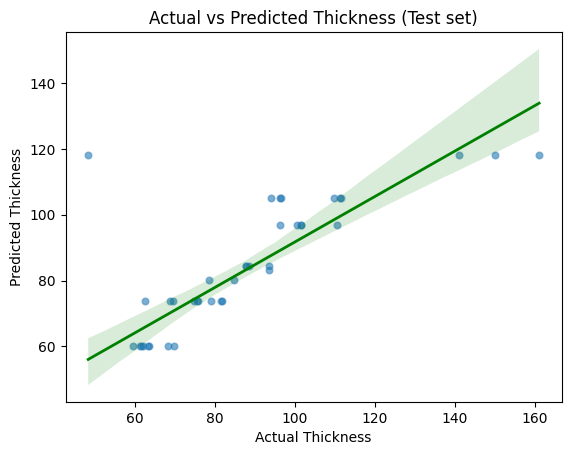

In [18]:
# Plotting the actual vs predicted values
sns.scatterplot(x=y_test.values, y=y_pred, alpha=0.4)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, robust=True)

plt.xlabel('Actual Thickness')
plt.ylabel('Predicted Thickness')
plt.title('Actual vs Predicted Thickness (Test set)')
plt.show()

In [19]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,75.533333,73.820000
1,61.300000,60.035417
2,68.700000,73.820000
3,96.633333,104.980952
4,101.466667,96.838095
5,63.166667,60.035417
6,69.433333,73.820000
7,96.266667,96.838095
8,61.466667,60.035417
9,111.533333,104.980952


In [20]:
mse = np.mean((y_test.values - y_pred)**2)
mse


248.04608115100433

In [21]:
# 테스트 세트에서의 RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

15.749478758073371